# How to model the charging duration (or parking duration) for e-cars at supermarkets?
According to **EHI-WHITEPAPER Elektromobilität im Handel 2023** the average charging times are
| Duration  | Percentage    |
| ---       | ---           | 
| max. 30 mins. | 15%       |
| 30-60mins.    | 50%       | 
| 60-120mins.   | 31%       |
| <120mins.     | 4%        |

Based on these figures we can create some sample data to work with:

Assumption 1: we take the midpoint per interval for our samples, e.g. we use 90mins for the interval from 60-120mins.

Assumption 2: max. parking duration is 5 hours (--> midpoint = 210min)

In [22]:
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

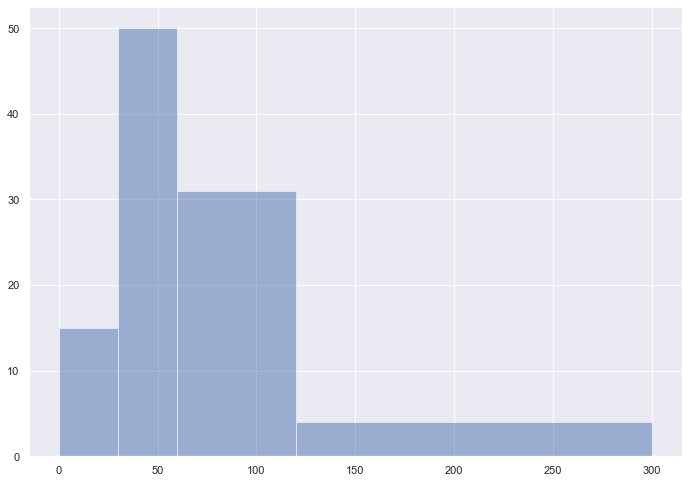

In [23]:
# 100 sample values following the distribution above
parking_duration_sample=[ \
    15, 15, 15, 15, 15, 15, 15, 15, 15, 15, \
    15, 15, 15, 15, 15, 45, 45, 45, 45, 45, \
    45, 45, 45, 45, 45, 45, 45, 45, 45, 45, \
    45, 45, 45, 45, 45, 45, 45, 45, 45, 45, \
    45, 45, 45, 45, 45, 45, 45, 45, 45, 45, \
    45, 45, 45, 45, 45, 45, 45, 45, 45, 45, \
    45, 45, 45, 45, 45, 90, 90, 90, 90, 90, \
    90, 90, 90, 90, 90, 90, 90, 90, 90, 90, \
    90, 90, 90, 90, 90, 90, 90, 90, 90, 90, \
    90, 90, 90, 90, 90, 90, 210, 210, 210, 210\
        ]

plt.hist(parking_duration_sample, bins = [0, 30, 60, 120, 300], alpha=0.5)
# plt.hist(parking_duration_sample, alpha=0.5)
plt.show()

With SciPy we can fit our sample data against various distributions. We will test 3 different distributions in the following:
- Normal distribution (only for testing because we can see already from the histogram that our data is right skewed)
- Lognormal distribution (used in HertleinEtAl_2023 for parking duration in inner-city garages)
- Weibull distribution

In [24]:
bins=range(300)

In [25]:
# NORMAL
(mu, sigma) = stats.norm.fit(parking_duration_sample)
print(mu, sigma)
y = stats.norm.pdf(bins, mu, sigma)

61.05 39.92677672940805


In [26]:
# lognormal
shape, loc, scale = stats.lognorm.fit(parking_duration_sample)
print(shape, loc, scale)
y2 = stats.lognorm.pdf(bins, shape, loc=loc, scale=scale)

7.6614069750922775 14.999999999999998 3.04989671736646


In [27]:
# WEIBULL
a_out, Kappa_out, loc_out, Lambda_out = stats.exponweib.fit(parking_duration_sample)
y3=stats.exponweib.pdf(bins, a=a_out,c=Kappa_out,loc=loc_out,scale = Lambda_out)
print(a_out, Kappa_out, loc_out, Lambda_out)

39.857766124920076 0.65117444343909 -20.724236876543387 8.472003942187907


In [28]:
# genarate random vars according to chosen distribution
r2 = stats.lognorm.rvs(shape, loc=loc, scale=scale, size=1000) 
df2 = pd.DataFrame(r2)
df2.describe()

,0
count,1.000000e+03
mean,5.366012e+06
std,8.485121e+07
min,1.500000e+01
25%,1.501099e+01
50%,1.700210e+01
75%,4.272688e+02
max,2.528539e+09


In [29]:
r3= stats.exponweib.rvs(a_out, Kappa_out, loc=loc_out, scale=Lambda_out, size=1000)
df3 = pd.DataFrame(r3)
df3.describe()

,0
count,1000.000000
mean,62.894709
std,41.004410
min,-0.096472
25%,34.867004
50%,54.369955
75%,79.678931
max,312.374846


The fitted lognormal distribution shows extremely large values which skrew up the whole distribution. Thus, with the provided data lognormal is not applicable or requires more parameter tuning!

We do not see these outliers with Weibull but the minimum could be negative! These needs to be handled when used in the simulation model.

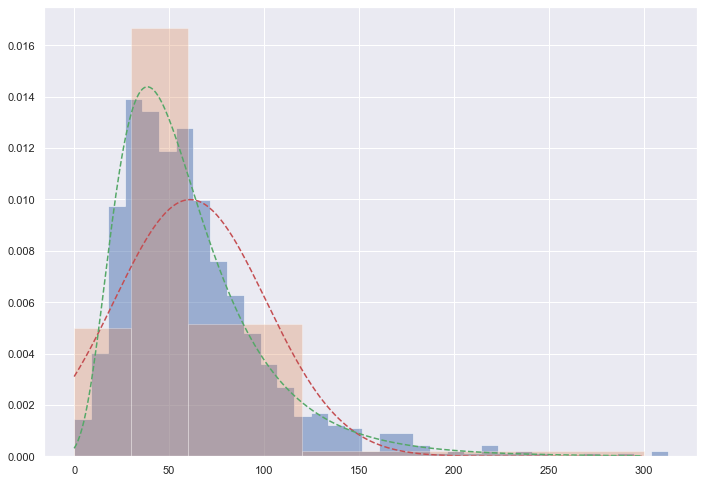

In [30]:
# Plotting
plt.plot(bins, y, 'r--')
#plt.plot(bins, y2, 'b.')
plt.plot(bins, y3, 'g--')
plt.hist(r3,density=True, bins='auto', histtype='stepfilled', alpha=0.5)
plt.hist(parking_duration_sample, bins = [0, 30, 60, 120, 300], density=True, alpha=0.3)

plt.show()

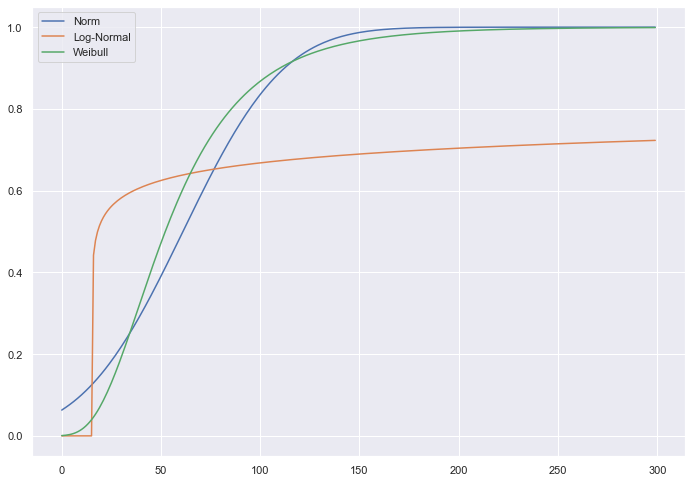

In [31]:
# CDF plotting
plt.plot(bins, stats.norm.cdf(bins, mu, sigma), label='Norm')
plt.plot(bins, stats.lognorm.cdf(bins, shape, loc=loc, scale=scale), label='Log-Normal')
plt.plot(bins, stats.exponweib.cdf(bins, a=a_out,c=Kappa_out,loc=loc_out,scale = Lambda_out), label='Weibull')

plt.legend()
plt.show()

## Conclusion
We have very limited data on the charging duration but can test in our simulation model a Weibull distribution for the duration with the following parameters
$$a=39.857766124920076$$
$$c=0.65117444343909$$
$$loc=-20.724236876543387$$
$$scale=8.472003942187907$$

Additional exception handling is needed if negative values are returned!

A charging duration for the next e-car can be computed with:

In [32]:
charge_time = stats.exponweib.rvs(a_out, Kappa_out, loc=loc_out, scale=Lambda_out, size=1)
print(charge_time)


[51.6987931]


With this returned numbers, we can run our simulation model and see the effect in the output

'VW_ID3_Pure' charged. Anzahl geladener EVs: 1
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 2
'VW_ID3_Pure' charged. Anzahl geladener EVs: 3
'VW_ID3_Pure' charged. Anzahl geladener EVs: 4
Alle Ladesäulen belegt. Abgewiesene EVs:  1
Alle Ladesäulen belegt. Abgewiesene EVs:  2
Alle Ladesäulen belegt. Abgewiesene EVs:  3
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 5
'VW_ID3_Pure' charged. Anzahl geladener EVs: 6
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 7
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 8
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 9
Alle Ladesäulen belegt. Abgewiesene EVs:  4
'VW_ID3_Pure' charged. Anzahl geladener EVs: 10
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 11
'VW_ID3_Pure' charged. Anzahl geladener EVs: 12
'VW_ID3_Pure' charged. Anzahl geladener EVs: 13
'VW_ID3_Pure' charged. Anzahl geladener EVs: 14
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 15
'VW_ID3_Pure' charged. Anzahl geladener EVs: 16
'Tesla_Model_3_LR' charged. An

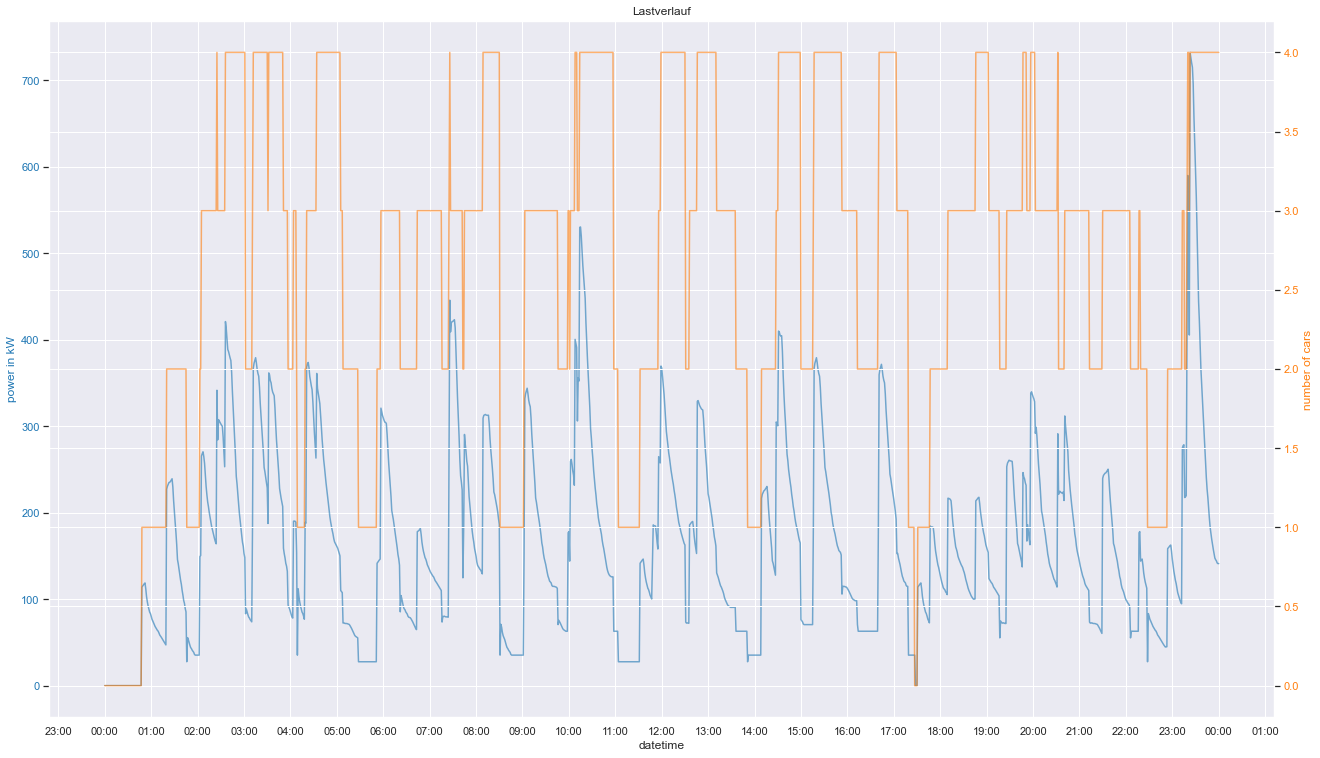

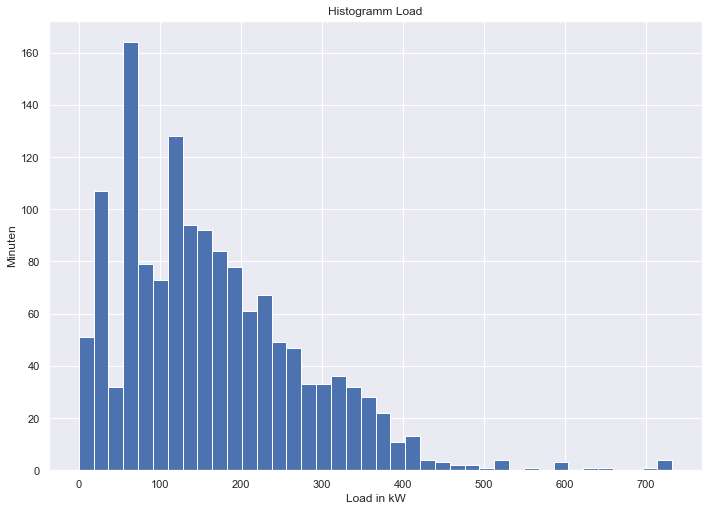

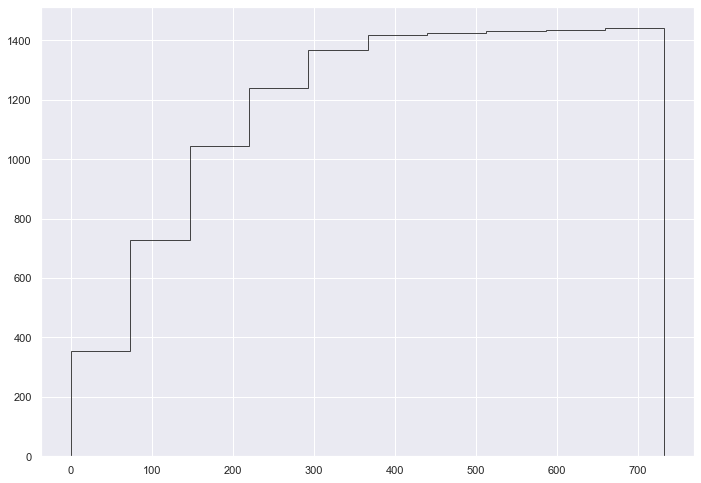

,power_per_minute,number_cars_charging
count,1441.000000,1441.000000
mean,165.550487,2.634282
std,112.890101,1.126162
min,0.000000,0.000000
25%,73.875822,2.000000
50%,145.413534,3.000000
75%,228.821798,4.000000
max,732.498250,4.000000


In [42]:
import importlib
# import random
import pandas as pd
# import matplotlib.dates as mdates
import json
import numpy as np
import matplotlib.pyplot as plt
import model_v2
importlib.reload(model_v2)

with open("settings_model_charging-time.json", "r") as f:
    settings = json.load(f)

df_results_returned = model_v2.simulation("settings_model_charging-time.json")
model_v2.plot(df_results_returned)
df_results_returned.describe()


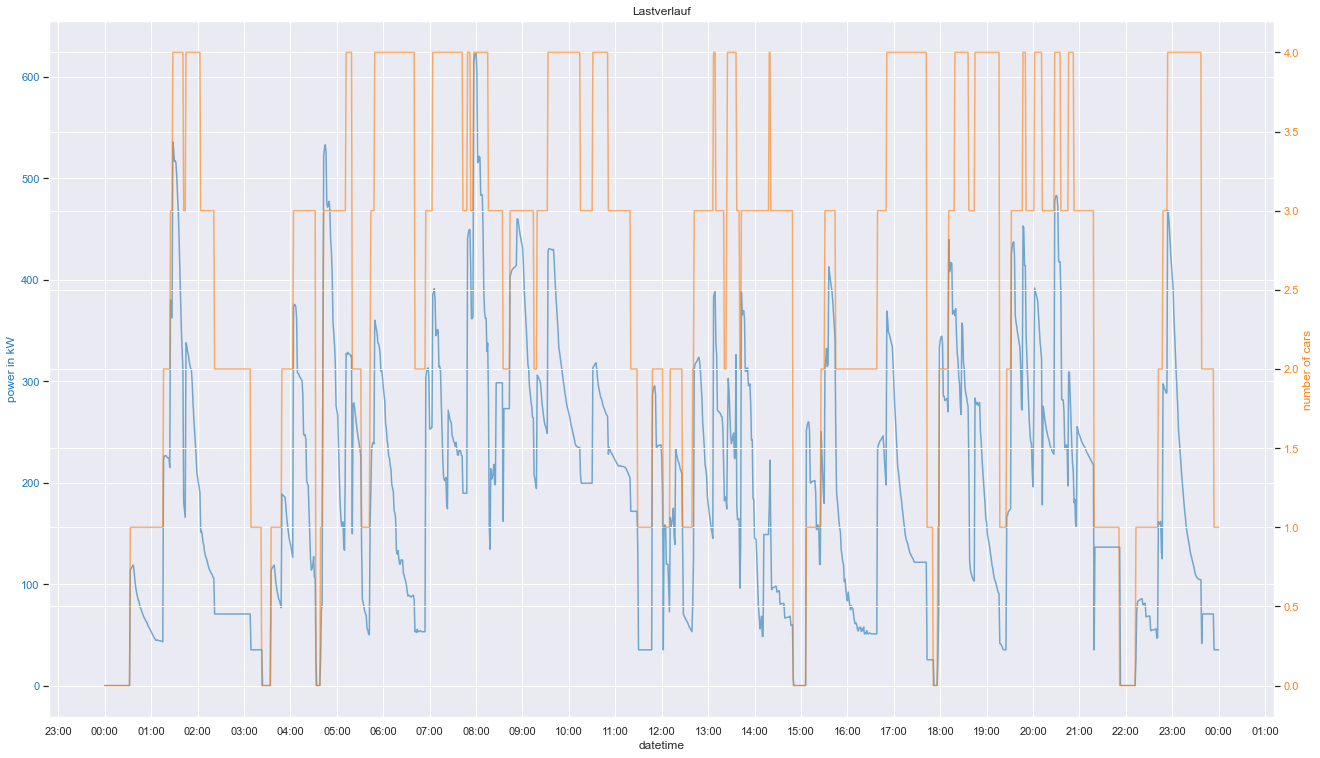

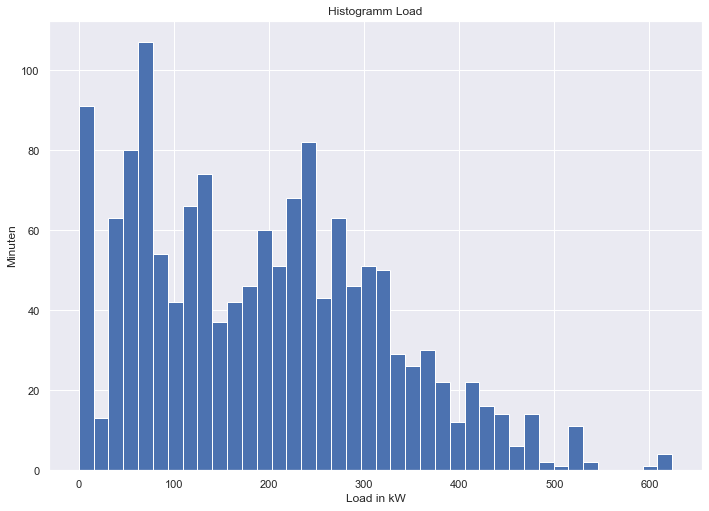

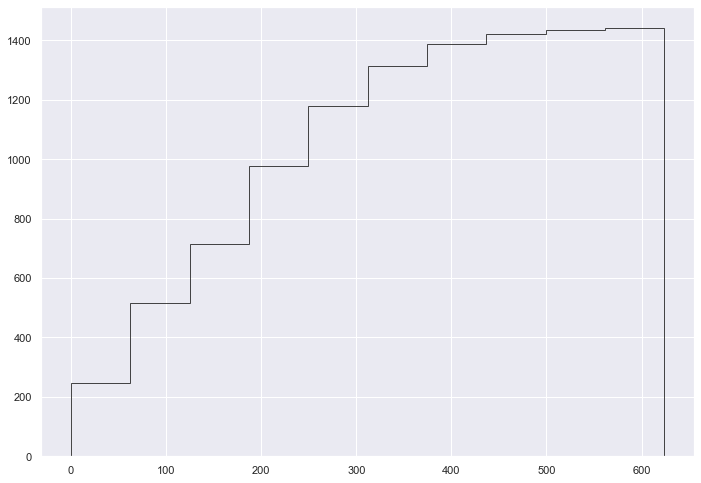

In [34]:
model_v2.plot(df_results_returned)

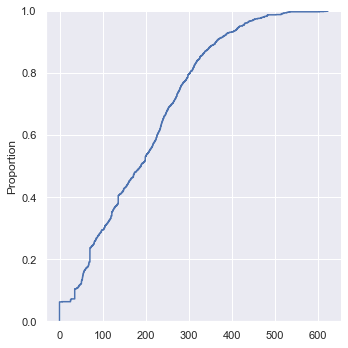

In [35]:
import seaborn as sns
sns.displot(np.asarray(df_results_returned['power_per_minute']), kind="ecdf")

## Mehrere Durchläuife

In folgendem Abschnitt wird die Simulation iterativ mehrere Male ausgeführt. Folglich kann ein gemittelter CDF-Plot zur Auswertung erstellt werden

In [36]:
df_results_10_runs = pd.DataFrame()
df_results_10_runs_single_row = pd.DataFrame()

for i in range(10):
    df_results_returned = model_v2.simulation("settings_model_charging-time.json")
    df_results_10_runs[("load_run", i)] = df_results_returned.power_per_minute
    df_results_10_runs_single_row = pd.concat([df_results_10_runs_single_row, df_results_returned])

'Porsche_Taycan' charged. Anzahl geladener EVs: 53
Alle Ladesäulen belegt. Abgewiesene EVs:  1
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 54
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 55
'FIAT_500e_Hatchback_2021' charged. Anzahl geladener EVs: 56
'VW_ID3_Pure' charged. Anzahl geladener EVs: 57
'Tesla_Model_3_LR' charged. Anzahl geladener EVs: 58
Alle Ladesäulen belegt. Abgewiesene EVs:  2
'VW_ID3_Pure' charged. Anzahl geladener EVs: 59
'VW_ID3_Pure' charged. Anzahl geladener EVs: 60
'Porsche_Taycan' charged. Anzahl geladener EVs: 61
'FIAT_500e_Hatchback_2021' charged. Anzahl geladener EVs: 62
'Tesla_Model_S-X_LR' charged. Anzahl geladener EVs: 63
Alle Ladesäulen belegt. Abgewiesene EVs:  3
'Porsche_Taycan' charged. Anzahl geladener EVs: 64
'VW_ID3_Pure' charged. Anzahl geladener EVs: 65
'VW_ID3_Pure' charged. Anzahl geladener EVs: 66
'FIAT_500e_Hatchback_2021' charged. Anzahl geladener EVs: 67
Alle Ladesäulen belegt. Abgewiesene EVs:  4
'Tesla_Model_S-X_LR' charged. Anza

In [37]:
df_results_10_runs.describe()

,"(load_run, 0)","(load_run, 1)","(load_run, 2)","(load_run, 3)","(load_run, 4)","(load_run, 5)","(load_run, 6)","(load_run, 7)","(load_run, 8)","(load_run, 9)"
count,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000
mean,181.368284,175.583398,154.589019,181.173644,177.630455,151.373827,157.071226,168.914522,166.648777,166.493283
std,130.005446,135.809152,115.564892,115.011662,111.918915,125.386973,100.119335,101.955905,111.300452,123.165687
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,76.794484,69.085290,67.561669,96.847135,109.305441,42.140315,88.001983,88.125009,70.918762,79.966365
50%,171.093262,154.866510,136.476868,164.341637,165.069865,126.302876,152.376486,166.069473,142.971128,140.012762
75%,262.879202,264.057658,204.449102,260.902160,249.437144,246.634444,209.514108,228.867714,239.454426,222.669039
max,659.474421,690.027503,666.792069,546.725928,552.452262,553.838384,546.169158,585.477820,504.159076,655.978648


Anschließend wird über die Durchläufe gemittelt der CDF geplottet

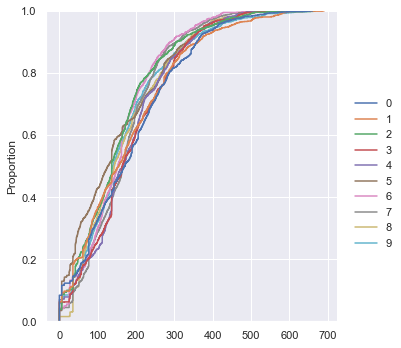

In [38]:
sns.displot(df_results_10_runs.values, kind="ecdf")

In [39]:
df_results_10_runs_single_row.describe()

,power_per_minute,number_cars_charging
count,14410.000000,14410.000000
mean,168.084643,2.399098
std,117.961666,1.161227
min,0.000000,0.000000
25%,76.794484,2.000000
50%,150.501524,2.000000
75%,238.823940,3.000000
max,690.027503,4.000000


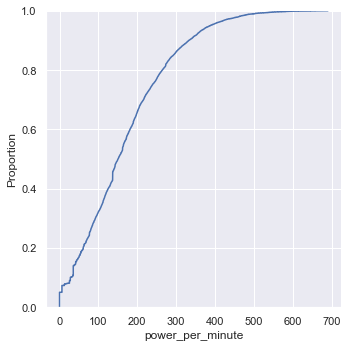

In [40]:
# plt.figure(figsize=(15, 10)) # width and height in inches
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.displot(df_results_10_runs_single_row.power_per_minute, kind="ecdf")